# Load Needed Packages

#### Note: if you want to change precision or device of JAX, the best way to do it is to follow (as an example)
#### `conda activate <your env name>`
#### `conda env config vars set JAX_ENABLE_X64=True`
#### `conda env config vars set jax_platform_name=cpu`
#### `conda activate <your env name>`
#### Make sure to restart VScode or jupyter notebook after this! `jax.config.update()` may or may not work because I define default jax arrays in different places.

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jar
# jax.config.update('jax_platform_name', 'cuda')
# jax.config.update("jax_enable_x64", False)
import numpy as np
from pandora import models, utils, GWBFunctions
from pandora import LikelihoodCalculator as LC
from enterprise_extensions.model_utils import get_tspan
import pickle, json, os, corner, glob, random, copy, time, inspect
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines

plt.style.use('dark_background')
hist_settings = dict(
    bins = 40,
    histtype = 'step',
    lw = 3,
    density = True
)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
# %load_ext line_profiler

/home/koonima/anaconda3/envs/pandora/lib/python3.11/site-packages/pandora/GWBFunctions.py:11: UserWarning: The package `interpax` is needed for spline interpolation of ORF.
  warnings.warn("The package `interpax` is needed for spline interpolation of ORF.")


Optional mpi4py package is not installed.  MPI support is not available.


# Choose a data set

In [2]:
datadir = ...
with open(datadir + f'v1p1_de440_pint_bipm2019.pkl', 'rb') as fin:
    psrs = pickle.load(fin)
psrlist = [psr.name for psr in psrs]
with open(datadir + f'v1p1_all_dict.json', 'r') as fin:
    noise_dict = json.load(fin)
inc_ecorr = True
backend = 'backend'
tnequad = False

libstempo not installed. Will use PINT instead.


# Step 1: Model Construction

## Frequency-bins

In [3]:
Tspan = get_tspan(psrs) # The time-span of the entire PTA
crn_bins = 5 # number of frequency-bins for the GWB
int_bins = 5 # number of frequency-bins for the non-GWB (IRN) red noise
assert int_bins >= crn_bins
f_intrin = jnp.arange(1/Tspan, (int_bins + 0.01)/Tspan, 1/Tspan) # an array of frequency-bins for the IRN process
f_common = f_intrin[:crn_bins] # an array of frequency-bins for the common process
renorm_const = 1 # the factor by which the units are going to change (divided by). Set it to `1` for no unit change (seconds), or let it be `1e9` (nano seconds)

## GWB PSD model

### A dictionary is used to store the necessary information about GWB PSD. You can either use the `utils.param_order_help` to make your own dictionary or use one of the pre-made ones. Take a look at `GWBFunctions.py` for a list of supported PSD as well as GWB ORF functions.

### For example, choose a GWB with HD correlations and fixed spectral index (at 13/3) powerlaw PSD.

In [4]:
# chosen_psd_model, chosen_orf_model, gwb_helper_dictionary = utils.fixed_gamma_hd_pl(renorm_const=renorm_const, lower_amp=-16.0, upper_amp=-13.0)
chosen_psd_model, chosen_orf_model, gwb_helper_dictionary = utils.hd_spectrum(renorm_const=renorm_const,crn_bins=crn_bins)
# chosen_psd_model, chosen_orf_model, gwb_helper_dictionary = utils.varied_gamma_hd_pl(renorm_const=renorm_const)
# chosen_psd_model, chosen_orf_model, gwb_helper_dictionary = utils.varied_gamma_gt_pl(renorm_const=renorm_const)
# chosen_psd_model, chosen_orf_model, gwb_helper_dictionary = utils.varied_gamma_bin_orf_pl(renorm_const=renorm_const)
gwb_helper_dictionary

{'ordered_gwb_psd_model_params': array(['halflog10_rho'], dtype='<U13'),
 'varied_gwb_psd_params': [np.str_('halflog10_rho')],
 'gwb_psd_param_lower_lim': Array([-9., -9., -9., -9., -9.], dtype=float32),
 'gwb_psd_param_upper_lim': Array([-1., -1., -1., -1., -1.], dtype=float32)}

### Now, construct the model using `models.UniformPrior`

In [15]:
help(models.UniformPrior)

Help on class UniformPrior in module pandora.models:

class UniformPrior(builtins.object)
 |  UniformPrior(gwb_psd_func, orf_func, crn_bins, int_bins, f_common, f_intrin, df, psr_pos, Tspan, Npulsars, gwb_helper_dictionary, gamma_min=0, gamma_max=7, log10A_min=Array(-13.5, dtype=float32), log10A_max=Array(-6.5, dtype=float32), renorm_const=1000000000.0)
 |  
 |  A class to take care of prior and the phi-matrix construction based on uniform/log-uniform priors.
 |  
 |  :param gwb_psd_func: a PSD function from the `GWBFunctions` class
 |  :param orf_func: an orf function from the `GWBFunctions` class
 |  :param crn_bins: number of frequency-bins for the GWB
 |  :param int_bins: number of frequency-bins for the non-GWB (IRN) red noise
 |  :param `f_common`: an array of frequency-bins for the common process
 |  :param `f_intrin`: an array of frequency-bins for the IRN process
 |  :param df: the diffence between consecutive frequency-bins. It is usually 1/Tspan
 |  :param psr_pos: an array 

In [6]:
o = models.UniformPrior(gwb_psd_func = chosen_psd_model,
                orf_func = chosen_orf_model,
                crn_bins = crn_bins,
                int_bins = int_bins,
                f_common = f_common, 
                f_intrin = f_intrin,
                df = 1/Tspan,
                Tspan = Tspan, 
                Npulsars = len(psrs),
                psr_pos = [psr.pos for psr in psrs],
                gwb_helper_dictionary = gwb_helper_dictionary,
                gamma_min = 0,
                gamma_max = 7,
                log10A_min = -20 + 0.5 * jnp.log10(renorm_const), #`0.5 * jnp.log10(renorm_const)` is added to account for change in units,
                log10A_max = -11 + 0.5 * jnp.log10(renorm_const), #`0.5 * jnp.log10(renorm_const)` is added to account for change in units,
                renorm_const = renorm_const)

In [7]:
x0 = o.make_initial_guess(key = jar.key(100)) # Some random draw from the prior given an RNG key

In [8]:
phimat = o.get_phi_mat(x0)
phimat.shape

(5, 67, 67)

### Here is the phi-matrix. Note that this matrix is batched by `max(int_bins, crn_bins)` and is lower-triangular as fully populating phi (a positive definite matrix) is vain for computational purposes!

In [9]:
phimat[0]

Array([[ 2.2452413e-03,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 8.6509145e-04,  2.2452413e-03,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 6.4983824e-04,  1.0258732e-03,  2.2452413e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-2.2885248e-04,  2.9987677e-05,  2.0361642e-04, ...,
         2.2452413e-03,  0.0000000e+00,  0.0000000e+00],
       [-2.3625759e-04, -6.0336184e-05,  6.4187689e-06, ...,
         4.6961528e-04,  2.2452413e-03,  0.0000000e+00],
       [-2.4720747e-04, -5.4940087e-05,  3.4688212e-05, ...,
         6.3834060e-04,  1.0600914e-03,  2.2452413e-03]], dtype=float32)

# Step 2: Likelihood Calculation

In [10]:
help(LC.MultiPulsarModel)

Help on class MultiPulsarModel in module pandora.LikelihoodCalculator:

class MultiPulsarModel(builtins.object)
 |  MultiPulsarModel(run_type_object, device_to_run_likelihood_on, psrs, TNr=Array([False], dtype=bool), TNT=Array([False], dtype=bool), noise_dict=None, backend='none', tnequad=False, inc_ecorr=False, del_pta_after_init=True, matrix_stabilization=True)
 |  
 |  A class to calculate likelihood based on given IRN + GWB models (no deterministic signal)
 |  
 |  :param run_type_object: a class from `run_types.py`
 |  :param device_to_run_likelihood_on: the device (cpu, gpu, cuda, METAL) to perform likelihood calculation on.
 |  :param psrs: an enterprise `psrs` object. Ignored if `TNr` and `TNT` is supplied
 |  :param TNr: the so-called TNr matrix. It is the product of the basis matrix `F`
 |  with the inverse of the timing marginalized white noise covaraince matrix D and the timing residulas `r`.
 |  The naming convension should read FD^-1r but TNr is a more well-known name for

### Making the likelihood calculator object is easy. We never change the white noise for multi-pulsar analyses, so the sufficient data is really `TNr` and `TNT` matrices. Thus, you can either supply a `psrs` object to make a `TNr` and `TNT` from, or you can supply both `TNr` and `TNT` directly. `noise_dict`, `backend`, `tnequad`, and `inc_ecorr` are only used when `psrs` is supplied.

In [13]:
m  = LC.MultiPulsarModel(psrs = psrs,
                        device_to_run_likelihood_on = 'cuda',
                        TNr=jnp.array([False]),
                        TNT=jnp.array([False]),
                        run_type_object = o,
                        noise_dict = noise_dict, 
                        backend = 'backend', 
                        tnequad = False, 
                        inc_ecorr = True, 
                        del_pta_after_init = False,
                        matrix_stabilization = True)
m.pta.params;

The delta is 1e-06
Condition number of the TNT matrix before stabilizing is: 1.4019025e+19
Condition number of the TNT matrix after stabilizing is: 3.8098245e+16


In [16]:
m.get_lnliklihood(x0), m.get_lnliklihood_LU(x0)

(Array(44645.887, dtype=float32), Array(44644.133, dtype=float32))

# Comparisons to `enterprise`

In [17]:
x0 = o.make_initial_guess(key = jar.key(100))
x0.shape

(139,)

## phi-mat construction comparison

In [18]:
%timeit phi = o.get_phi_mat(x0)

107 μs ± 302 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [19]:
%timeit ent_phi = m.pta.get_phi(m.pta.map_params(x0))

30.6 ms ± 323 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Likelihood comparison

In [20]:
for _ in np.arange(1, 10, 1, dtype = int):
    x0 = o.make_initial_guess(key = jar.key(_))
    print(_, m.get_lnliklihood(x0), m.get_lnliklihood_LU(x0))

1 42917.008 43015.23
2 46228.07 46228.566
3 44521.938 44521.863
4 45336.49 45336.45
5 36164.27 36164.23
6 45998.96 45998.957
7 32574.158 32574.164
8 44651.66 44651.65
9 41871.99 41871.938


### White noise is fixed, so `rNr` is just a constant and does not need to be involved in likelihood calculations.

In [21]:
def lnlike_offset():
    likelihood_adjust = 0
    likelihood_adjust += -0.5 * np.sum([ell for ell in m.pta.get_rNr_logdet(params)])
    likelihood_adjust += sum(m.pta.get_logsignalprior(params))
    return likelihood_adjust

In [22]:
for _ in np.arange(1, 10, 1, dtype = int):
    x0 = o.make_initial_guess(key = jar.key(_))
    params = m.pta.map_params(x0)
    print(_, m.pta.get_lnlikelihood(params) - lnlike_offset())

1 43062.59033496864
2 46230.96412110608
3 44540.02723733708
4 45348.31234365888
5 36174.67928273883
6 46002.01543939207
7 32576.311695018783
8 44658.56784860697
9 41875.232200818136


### The likelihood values MUST match given same precision!

In [23]:
m.get_lnliklihood(x0)

Array(41871.99, dtype=float32)

In [24]:
m.pta.get_lnlikelihood(params) - lnlike_offset()

np.float64(41875.232200818136)

### The timing varies given precision, device (CPU or GPU), number of frequency-bins, and number of pulsars! To keep the comparison fair, you should use CPU and double precision. To get the best performance, you should use GPU and single-precision.

In [25]:
%timeit o.get_phi_mat(x0); m.get_lnliklihood(x0)

1.77 ms ± 30 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [23]:
%timeit m.pta.get_lnlikelihood(x0)

212 ms ± 32.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Sampling

## ENTERPRISE `pta` object sampling

In [ ]:
m.sample(x0 = np.array(x0), niter = int(1e6), savedir = '../testnew/Standard/', resume=True, sample_enterprise = True)

## `PANDORA` sampling

In [ ]:
m.sample(x0 = np.array(x0), niter = int(1e6), savedir = '../testnew/Standard_PANDORA_LU/', 
         resume=False, 
         sample_enterprise = False,
         LU_decomp = False)

## NUTS sampler

In [21]:
import blackjax
from blackjax.progress_bar import progress_bar_scan

In [22]:
m.get_lnliklihood(x0)

Array(44636.45207812, dtype=float64)

In [ ]:
warmup = blackjax.window_adaptation(blackjax.nuts, m.get_lnliklihood, progress_bar = True)
rng_key, warmup_key, sample_key = jax.random.split(jar.key(100), 3)
(state, parameters), _ = warmup.run(warmup_key, x0, num_steps=100)

In [ ]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    scan_fn = progress_bar_scan(num_samples, progress_bar=True)
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = scan_fn(one_step, initial_state, keys)

In [ ]:
kernel = blackjax.nuts(m.get_lnliklihood, **parameters).step

# Postprocessing

In [18]:
plt.style.use('default')
def figsize(scale, wc = 1, hc = 1):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [wc * fig_width,hc * fig_height]
    return fig_size
plt.rcParams.update(plt.rcParamsDefault)

params = {#'backend': 'pdf',
        'axes.labelsize': 12,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        "xtick.top": True,
        "ytick.right": True,
        "xtick.minor.visible": True,
        "xtick.major.top": True, 
        "xtick.minor.top": True,
        "ytick.minor.visible": True, 
        "ytick.major.right": True, 
        "ytick.minor.right": True,
        "ytick.direction": "in",
        "xtick.direction": "in",
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        "text.usetex": True,
        #'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        'figure.figsize': figsize(0.5, 1, 1)}
plt.rcParams.update(params)

In [19]:
chain_ent = np.loadtxt('../testnew/Standard/chain_1.txt')
chain_ent = chain_ent[int(0.25 * chain_ent.shape[0]):, :-4]
chain_ent.shape

(57225, 139)

In [20]:
chain_pan = np.loadtxt('../testnew/Standard_PANDORA/chain_1.txt')
chain_pan = chain_pan[int(0.25 * chain_pan.shape[0]):, :-4]
chain_pan.shape

(74925, 139)

In [21]:
chain_pan_ss = np.loadtxt('../testnew/Standard_PANDORA_LU/chain_1.txt')
chain_pan_ss = chain_pan_ss[int(0.25 * chain_pan_ss.shape[0]):, :-4]
chain_pan_ss.shape

(63150, 139)

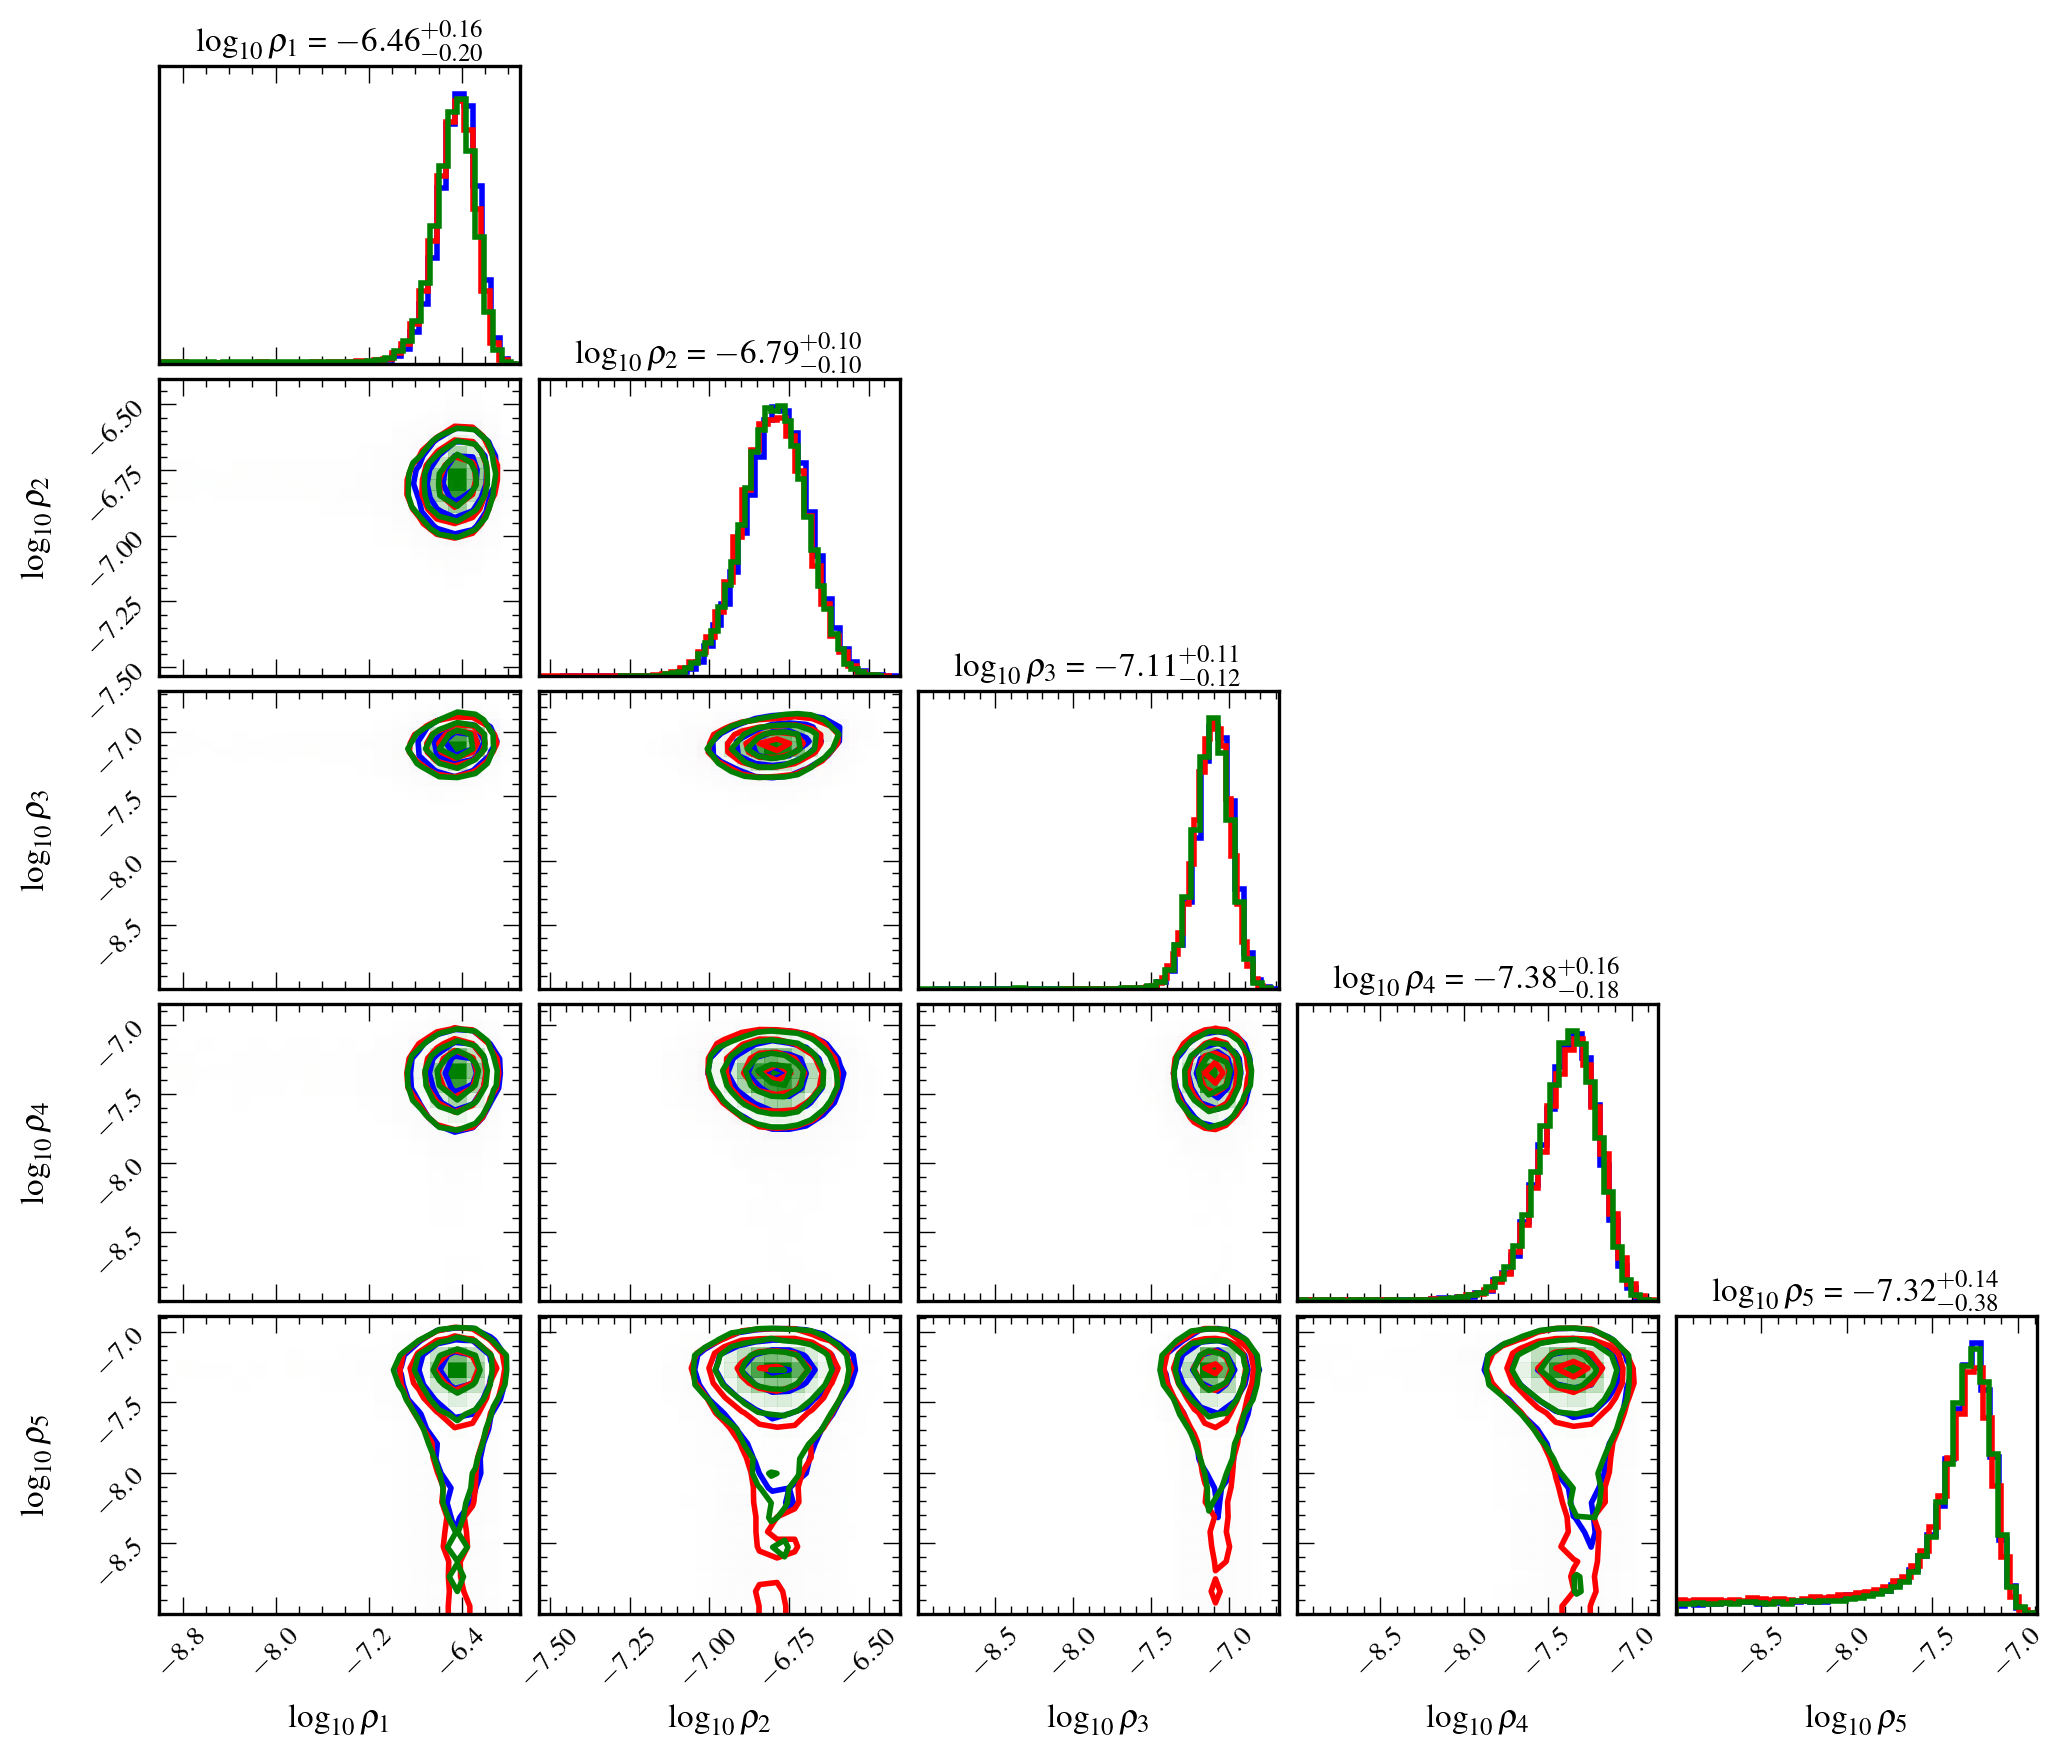

In [22]:
labels = [r'$\log_{{{0}}}\rho_{{{1}}}$'.format(10, _+1) for _ in range(5)]
fig = plt.figure(figsize=figsize(0.5, 3, 4))
fig = corner.corner(chain_ent[:, -crn_bins:], fig = fig, color='blue', bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, 
                    contour_kwargs={'linewidths':2}, labels = labels,show_titles = True,
            truth_color = 'red', desity = True, plot_datapoints = False)
fig = corner.corner(chain_pan[:, -crn_bins:], fig = fig, color='red', bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, 
                    contour_kwargs={'linewidths':2}, labels = labels,show_titles = True,
            truth_color = 'red', desity = True, plot_datapoints = False)

fig = corner.corner(chain_pan_ss[:, -crn_bins:], fig = fig, color='green', bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, 
                    contour_kwargs={'linewidths':2}, labels = labels,show_titles = True,
            truth_color = 'red', desity = True, plot_datapoints = False)

plt.show()

In [32]:
def Hellinger(p, q):
    diff = np.sqrt(p) - np.sqrt(q)
    return 1/np.sqrt(2) * np.sqrt(np.sum(diff**2, axis = 0))

In [44]:
h = []
for fidx in range(crn_bins):
            
        vh1, be = np.histogram(chain_ent[:, -crn_bins + fidx], 
                                density = False, bins = 20)
        vh0, _ = np.histogram(chain_pan[:, -crn_bins + fidx],
                                density = False, bins = be)
        
        h.append(Hellinger(vh1/vh1.sum(), vh0/vh0.sum()))

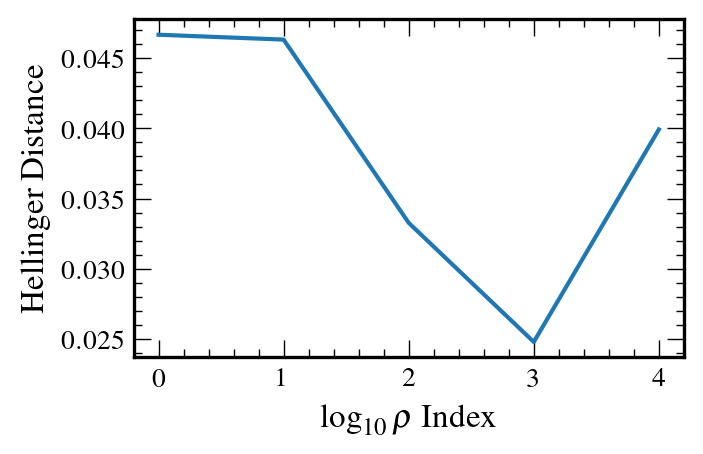

In [45]:
plt.plot(h)
plt.ylabel('Hellinger Distance')
plt.xlabel(r'$\log_{10}{\rho}$' + ' Index')
plt.show()

In [46]:
max(h)

0.04666367481521061